# MSOA mapping for Scotland

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import KNeighborsRegressor
import rasterio as rst
from rasterstats import zonal_stats

%matplotlib inline

In [2]:
path = r"[CHANGE THIS PATH]\Scotland\\"

In [3]:
data = pd.read_csv(path + "final_data.csv", index_col = 0)

# Convert to GeoDataFrame

In [4]:
geo_data = gpd.GeoDataFrame(data = data, 
                            crs = {'init':'epsg:27700'}, 
                            geometry = data.apply(lambda geom: Point(geom['oseast1m'],geom['osnrth1m']),axis=1))
geo_data.head()

,pcstrip,Year,PracticeListSize,HBT2014,oseast1m,osnrth1m,lsoa11,msoa11,ru11ind,rgn,...,blood pressure_zscore,hypertension_zscore,diabeties_zscore,cardiovascular disease_zscore,insomnia_zscore,addiction_zscore,social anxiety_zscore,loneliness_zscore,loneills,geometry
0,AB101NW,2018,10517.75,S08000020,392709.0,805764.0,S01006571,S02001247,1.0,S99999999,...,-0.872323,-0.858960,-1.305914,-0.840871,0.380188,-0.094736,0.292477,-1.227636,-0.403287,POINT (392709 805764)
1,AB101QB,2018,8454.50,S08000020,393104.0,805894.0,S01006571,S02001247,1.0,S99999999,...,0.349315,0.347988,-1.073669,0.594191,0.606838,0.180684,7.937173,0.421671,9.003381,POINT (393104 805894)
2,AB101UT,2018,8601.25,S08000020,393051.0,806083.0,S01006584,S02001249,1.0,S99999999,...,0.064186,0.071906,-0.591043,0.442046,1.204977,0.872192,0.432447,0.758395,2.996948,POINT (393051 806083)
3,AB101YE,2018,9168.00,S08000020,393170.0,805747.0,S01006571,S02001247,1.0,S99999999,...,-0.777193,-0.768218,-0.651316,-0.641605,2.556367,0.548149,0.735681,-0.113232,4.412732,POINT (393170 805747)
4,AB107QQ,2018,10022.25,S08000020,391998.0,803177.0,S01006528,S02001239,1.0,S99999999,...,-1.285084,-1.285630,-1.106038,-0.816908,0.739858,0.392298,0.152986,-1.101059,1.270275,POINT (391998 803177)


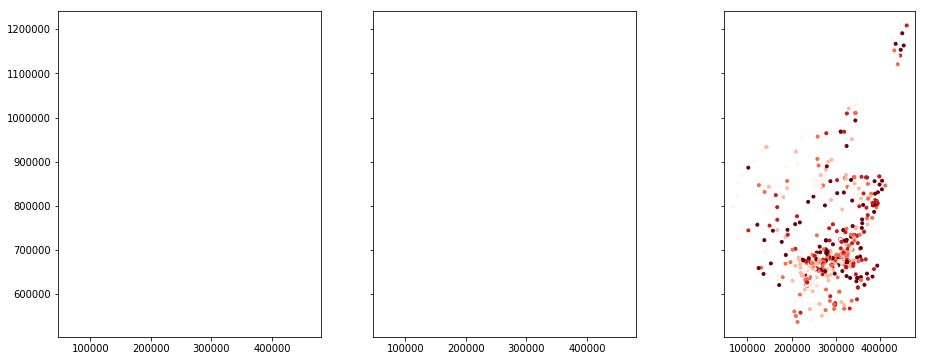

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,6), sharex = True, sharey = True)

# geo_data[geo_data['Year'] == 2016].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax1);
# geo_data[geo_data['Year'] == 2017].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax2);
geo_data[geo_data['Year'] == 2018].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax3);

## k-nearest neighbour interpolation

Non-parametric interpolation of loneliness based on local set of _k_ nearest neighbours for each cell in our evaluation grid.

Effectively becomes an inverse distance weighted (idw) interpolation when weights are set to be distance based.

In [6]:
def idw_model(k, p):
    def _inv_distance_index(weights, index=p):
        return (test==0).astype(int) if np.any(weights == 0) else 1. / weights**index
    return KNeighborsRegressor(k, weights=_inv_distance_index)

def grid(xmin, xmax, ymin, ymax, cellsize):
    # Set x and y ranges to accommodate cellsize
    xmin = (xmin // cellsize) * cellsize
    xmax = -(-xmax // cellsize) * cellsize # ceiling division
    ymin = (ymin // cellsize) * cellsize
    ymax = -(-ymax // cellsize) * cellsize
    # Make meshgrid
    x = np.linspace(xmin,xmax,(xmax-xmin)/cellsize)
    y = np.linspace(ymin,ymax,(ymax-ymin)/cellsize)
    return np.meshgrid(x,y)

def reshape_grid(xx,yy):
    return np.append(xx.ravel()[:,np.newaxis],yy.ravel()[:,np.newaxis],1)

def reshape_image(z, xx):
    return np.flip(z.reshape(np.shape(xx)),0)

def idw_surface(locations, values, xmin, xmax, ymin, ymax, cellsize, k=5, p=2):
    # Make and fit the idw model
    idw = idw_model(k,p).fit(locations, values)
    # Make the grid to estimate over
    xx, yy = grid(xmin, xmax, ymin, ymax, cellsize)
    # reshape the grid for estimation
    xy = reshape_grid(xx,yy)
    # Predict the grid values
    z = idw.predict(xy)
    # reshape to image array
    z = reshape_image(z, xx)
    return z

## 2016 data

In [ ]:
# Get point locations and values from data
# points = geo_data[geo_data['Year'] == 2016][['oseast1m','osnrth1m']].values
# vals = geo_data[geo_data['Year'] == 2016]['loneills'].values

# surface2016 = idw_surface(points, vals, 90000,656000,10000,654000,250,7,2)

In [ ]:
# Look at surface
# f, ax = plt.subplots(figsize = (8,10))
# ax.imshow(surface2016, cmap='Reds')
# ax.set_aspect('equal')

## 2017 Data

In [ ]:
# Get point locations and values from data
# points = geo_data[geo_data['Year'] == 2017][['oseast1m','osnrth1m']].values
# vals = geo_data[geo_data['Year'] == 2017]['loneills'].values

# surface2017 = idw_surface(points, vals, 90000,656000,10000,654000,250,7,2)

In [ ]:
# Look at surface
# f, ax = plt.subplots(figsize = (8,10))
# ax.imshow(surface2017, cmap='Reds')
# ax.set_aspect('equal')

## 2018 Data

Get minimum and maximum bounds from the data. Round these down (in case of the 'min's) and up (in case of the 'max's) to get the values for `idw_surface()`

In [7]:
print("xmin = ", geo_data['oseast1m'].min(), "\n\r",
      "xmax = ", geo_data['oseast1m'].max(), "\n\r",
      "ymin = ", geo_data['osnrth1m'].min(), "\n\r",
      "ymax = ", geo_data['osnrth1m'].max())

xmin =  66531.0 
 xmax =  461080.0 
 ymin =  536471.0 
 ymax =  1208925.0


In [8]:
xmin = 66000
xmax = 462000
ymin = 536000
ymax = 1210000

In [9]:
# Get point locations and values from data
points = geo_data[geo_data['Year'] == 2018][['oseast1m','osnrth1m']].values
vals = geo_data[geo_data['Year'] == 2018]['loneills'].values

surface2018 = idw_surface(points, vals, xmin,xmax,ymin,ymax,250,7,2)

C:\Users\...\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Users\...\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


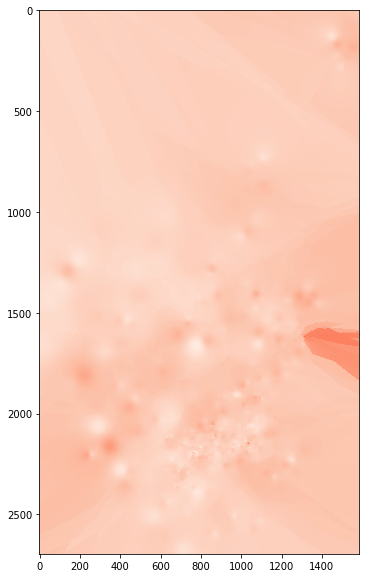

In [10]:
# Look at surface
f, ax = plt.subplots(figsize = (8,10))
ax.imshow(surface2018, cmap='Reds')
ax.set_aspect('equal')

# Extract Values to MSOAs

Get 2011 MSOAs from the Open Geography Portal: http://geoportal.statistics.gov.uk/

In [11]:
# Get MSOAs which we use to aggregate the loneills variable.
filestring = r'[CHANGE THIS PATH]\Data\Boundaries\Scotland\SG_IntermediateZone_Bdry_2011.shp'

msoas = gpd.read_file(filestring)
msoas.to_crs({'init':'epsg:27700'})

,InterZone,Name,TotPop2011,ResPop2011,HHCnt2011,StdAreaHa,StdAreaKm2,Shape_Leng,Shape_Area,geometry
0,S02001236,Culter,4845,4733,2143,1955.371256,19.553709,32691.386863,1.955371e+07,"POLYGON ((379360.1996999998 804844.9999999991,..."
1,S02001237,"Cults, Bieldside and Milltimber West",4007,3751,1428,1975.883716,19.758838,30785.797245,1.975884e+07,"POLYGON ((383981.1815999998 806104.6009999994,..."
2,S02001238,"Cults, Bieldside and Milltimber East",6112,5850,2291,527.511832,5.275116,16435.348821,5.275118e+06,"POLYGON ((389550.5565999998 803884.6099999996,..."
3,S02001239,Garthdee,5229,5152,2439,149.371708,1.493716,6337.117919,1.493717e+06,"POLYGON ((392625.9995999997 804064, 392631.999..."
4,S02001240,"Braeside, Mannofield, Broomhill and Seafield East",4419,4358,2193,83.772094,0.837722,6128.030325,8.377209e+05,"POLYGON ((393251.0076000001 805451.0329999992,..."
5,S02001241,"Braeside, Mannofield, Broomhill and Seafield S...",3831,3797,1754,110.814629,1.108145,7092.461126,1.108146e+06,"POLYGON ((391334.0696 804635.9920000003, 39138..."
6,S02001242,"Braeside, Mannofield, Broomhill and Seafield N...",4564,4508,2214,141.622217,1.416221,9258.757972,1.416222e+06,"POLYGON ((391497.8536 805656.0140000001, 39150..."
7,S02001243,Hazlehead,4946,4908,2318,899.818435,8.998186,21632.160030,8.998184e+06,"POLYGON ((389389.2396 806346.1889999988, 38947..."
8,S02001244,Summerhill,3911,3820,1848,113.167710,1.131679,6727.629944,1.131677e+06,"POLYGON ((391055.8376000002 806753.1170000008,..."
9,S02001245,Midstocket,4572,4507,2081,154.473813,1.544740,7562.379883,1.544738e+06,"POLYGON ((392424.9995999997 807470.0000000001,..."


In [41]:
# Get GB countries data to use for representation
#gb = gpd.read_file('./Data/GB/Countries_December_2017_Generalised_Clipped_Boundaries_in_UK_WGS84.shp')
#gb = gb.to_crs({'init':'epsg:27700'})
# get England
#eng = gb[gb['ctry17nm'] == 'England'].copy()

In [12]:
# Make affine transform for raster
trans = rst.Affine.from_gdal(xmin-125,250,0,ymax+125,0,-250)

In [13]:
# NB This process is slooow - write bespoke method?
# 2016
#msoa_zones = zonal_stats(msoas['geometry'], surface2016, affine = trans, stats = 'mean', nodata = np.nan)
#msoas['loneills_2016'] = list(map(lambda x: x['mean'] , msoa_zones))
# 2017
#msoa_zones = zonal_stats(msoas['geometry'], surface2017, affine = trans, stats = 'mean', nodata = np.nan)
#msoas['loneills_2017'] = list(map(lambda x: x['mean'] , msoa_zones))
# 2018
msoa_zones = zonal_stats(msoas['geometry'], surface2018, affine = trans, stats = 'mean', nodata = np.nan)
msoas['loneills_2018'] = list(map(lambda x: x['mean'] , msoa_zones))

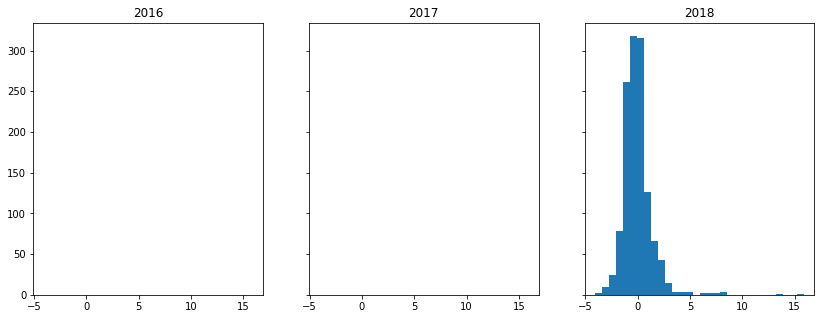

In [14]:
# Check out the distributions of loneills by MSOA
f, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(14,5), sharex = True, sharey=True)

#ax1.hist(msoas['loneills_2016'], bins = 30)
#ax2.hist(msoas['loneills_2017'], bins = 30)
ax3.hist(msoas['loneills_2018'], bins = 30)

ax1.set_title("2016")
ax2.set_title("2017")
ax3.set_title("2018");

In [22]:
bins = [-10, -5, -3, -2, -1, 1, 2, 3, 5, 10, 22]
labels = ['#01665e','#35978f', '#80cdc1','#c7eae5','#f5f5f5','#f6e8c3','#dfc27d','#bf812d','#8c510a','#543005']

#msoas['loneills_2016_class'] = pd.cut(msoas['loneills_2016'], bins, labels = labels)
#msoas['loneills_2017_class'] = pd.cut(msoas['loneills_2017'], bins, labels = labels)
msoas['loneills_2018_class'] = pd.cut(msoas['loneills_2018'], bins, labels = labels)

msoas['loneills_2018_class'] = msoas.loneills_2018_class.astype(str)  # convert categorical to string

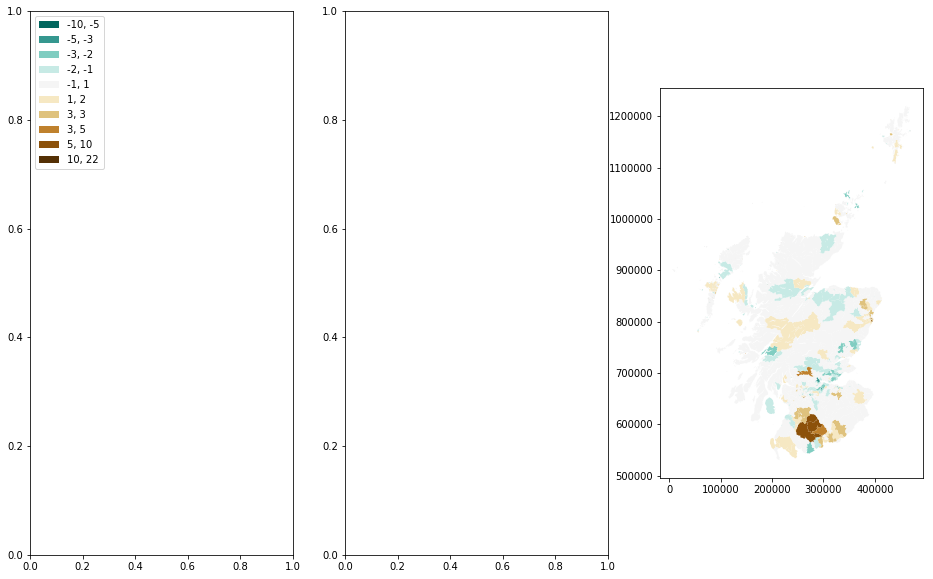

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (16,10))

#msoas.plot(color = msoas['loneills_2016_class'], ax=ax1)
#msoas.plot(color = msoas['loneills_2017_class'], ax=ax2)
msoas.plot(color = msoas['loneills_2018_class'], ax=ax3)

#gb.plot(edgecolor = 'k', linewidth = 0.5, facecolor='none', ax=ax1)
#gb.plot(edgecolor = 'k', linewidth = 0.5, facecolor='none', ax=ax2)
#gb.plot(edgecolor = 'k', linewidth = 0.5, facecolor='none', ax=ax3)

# restrict to England
#ax1.set_xlim([82672,656000])
#ax1.set_ylim([5342,658000])
#ax2.set_xlim([82672,656000])
#ax2.set_ylim([5342,658000])
#ax3.set_xlim([82672,656000])
#ax3.set_ylim([5342,658000])

# Make a legend
# make bespoke legend
from matplotlib.patches import Patch
handles = []
ranges = ["-10, -5","-5, -3","-3, -2","-2, -1","-1, 1","1, 2","3, 3","3, 5","5, 10","10, 22"]
for color, label in zip(labels,ranges):
    handles.append(Patch(facecolor = color, label = label))

ax1.legend(handles = handles, loc = 2);

In [25]:
# Save out msoa data as shapefile and geojson
msoas.to_file(path + "msoa_loneliness.shp", driver = 'ESRI Shapefile')
msoas.to_file(path + "msoa_loneliness.geojson", driver = 'GeoJSON')

GeometryTypeValidationError: Record's geometry type does not match collection schema's geometry type: 'MultiPolygon' != 'Polygon'

In [28]:
# save out msoa data as csv
msoas[['InterZone', 'Name', 'loneills_2018', 'loneills_2018_class']].to_csv(path + "msoa_loneliness.csv")